In [116]:
import pandas as pd
import sys
sys.path.insert(1, '../../../../scripts/')
from s3_support import *
%matplotlib inline

# load & prep data

## google traffic

In [117]:
q = '''select
            date_trunc('week', date) as date,
            org,
            form,
            sum(views) as pageviews
        from googleanalytics_traffic
            where date>=2018
        group by date_trunc('week', date), org, form;'''
pageviews = redshift_query_read(q)

In [118]:
pageviews = pageviews[pageviews['form']!=0]
pageviews['date'] = pd.to_datetime(pageviews['date'])
len(pageviews), len(pageviews['form'].unique())

(665076, 20572)

## transactions

In [119]:
q = '''select 
            form, 
            date_trunc('week', date) as date,
            count(id) as count, 
            sum(amount) as vol
        from transactions
        where status='A' and date>=2018 and source='p2p'
        group by form, date_trunc('week', date)
    '''
trans = redshift_query_read(q)

In [120]:
trans['date'] = pd.to_datetime(trans['date'])

In [121]:
len(trans), len(trans['form'].unique())

(41835, 4579)

## analytics data

In [122]:
q = "select * from analytics_weekly where date>=2018"
df_base = redshift_query_read(q)
print("done with analytics")

q = "select * from analyticsp2p_weekly where date>=2018"
df_p2p = redshift_query_read(q)
print("done with analyticsqgiv")

done with analytics
done with analyticsqgiv


In [123]:
p2p_forms = df_p2p['form'].tolist()
df_base = df_base[df_base['form'].isin(p2p_forms)]

df_analytics = df_base.merge(df_p2p, on=["org", "form", "date"]).dropna()

df_analytics = df_analytics.drop(['org', 'product'], axis=1).groupby(['date', 'form']).sum().reset_index()

df_analytics['date'] = pd.to_datetime(df_analytics['date'])

## merge data

In [124]:
# narrow dataset to forms in p2p analytics
pageviews = pageviews[pageviews['form'].isin(p2p_forms)]
trans = trans[trans['form'].isin(p2p_forms)]

# merge traffic and transactions
trans_n_views = trans.merge(pageviews, on=['form', 'date'])
trans_n_views.columns = ['form', 'date', 'trans_count', 'trans_vol', 'org', 'pageviews']
trans_n_views['conversion'] = trans_n_views['trans_count'] / trans_n_views['pageviews']
trans_n_views['avg_trans'] = trans_n_views['trans_vol'] / trans_n_views['trans_count']

In [125]:
trans_n_views.head(3)

,form,date,trans_count,trans_vol,org,pageviews,conversion,avg_trans
0,931777,2018-02-05,18,2610.0,433169,1369,0.013148,145.000000
1,929825,2018-02-19,35,898.4,433165,254,0.137795,25.668571
2,939221,2018-10-29,4,150.0,438371,4,1.000000,37.500000


In [126]:
df_an = df_analytics.merge(trans_n_views, on=['form', 'date'])

# Correlations

In [127]:
drop_cols = ['date', 'form', 'org', 'don_volume', 'don_count'] + [c for c in df_an.columns if '_trans_' in c]
# pd.set_option('display.max_rows', None)
corrs = df_an.drop(drop_cols, axis=1).corr()[['trans_count', 'trans_vol', 'pageviews', 'conversion', 'avg_trans']].dropna()
corrs

,trans_count,trans_vol,pageviews,conversion,avg_trans
sub_reg_count,0.261725,0.133591,0.248531,0.136132,-0.034336
teams_count,0.318299,0.170559,0.291130,0.108368,-0.050555
class_count,0.195910,0.107643,0.113828,-0.006661,-0.022243
cat_count,0.109342,0.074607,0.203454,0.025155,-0.027634
promo_count,0.100073,0.110270,0.118920,-0.007611,0.031974
rest_count,-0.014249,-0.018428,-0.017478,-0.002352,-0.010960
amt_count,0.066077,0.017291,0.074658,-0.006948,0.051221
ded_count,-0.048737,-0.032226,-0.042252,0.025214,-0.015980
fields,-0.022794,0.014313,-0.054431,0.050635,0.129013
opt_fields,-0.028075,-0.018023,-0.057639,0.015824,0.038524


In [128]:
corrs[corrs>0.1].dropna()

,trans_count,trans_vol,pageviews,conversion,avg_trans
trans_vol,0.784782,1.0,0.627829,0.201327,0.138921


In [129]:
high_corr_cols = list(corrs[corrs>0.1].dropna().index) + ['cat_count', 'allows_reg_team_join']

In [143]:
['sub_reg_count', 'teams_count', 'class_count',
 'promo_count', 'allows_teams', 'trans_count',
 'trans_vol', 'pageviews', 'cat_count',
 'allows_reg_team_join']

['sub_reg_count',
 'teams_count',
 'class_count',
 'promo_count',
 'allows_teams',
 'trans_count',
 'trans_vol',
 'pageviews',
 'cat_count',
 'allows_reg_team_join']

_It's worth noting that the teams count has a 29% correlation and sub registrants have a 24% correlation to page views. Related is the fact that teams count has a 32% correlation and sub registrants have a 26% correlation to transaction count. This might be indicative of teams & sub-registrants driving greater engagement and thus traffic._

The highly correlated actionable features are _sub_reg_count, teams_count, class_count, promo_count, allows_teams, allows_reg_team_join, and cat_count_. 

In [131]:
feature_cols = ['sub_reg_count', 'teams_count', 'class_count', 'promo_count',
                 'allows_teams', 'cat_count', 'allows_reg_team_join']

# Distributions

In [132]:
target_cols = ['trans_count', 'trans_vol', 'pageviews', 'conversion', 'avg_trans']

### sub_reg_count

In [133]:
buckets_subreg_count = df_an.groupby('sub_reg_count')[target_cols].mean().reset_index()

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


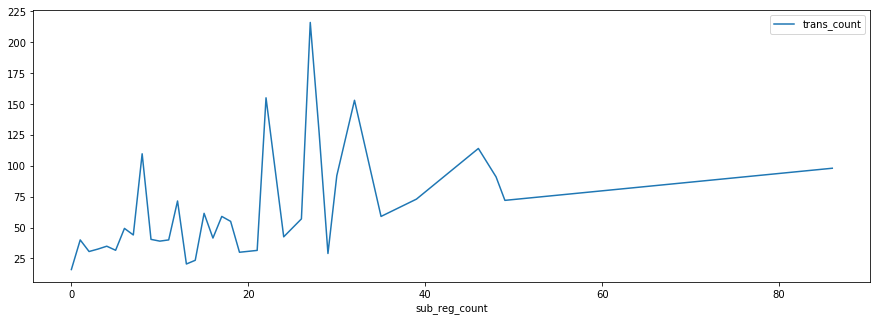

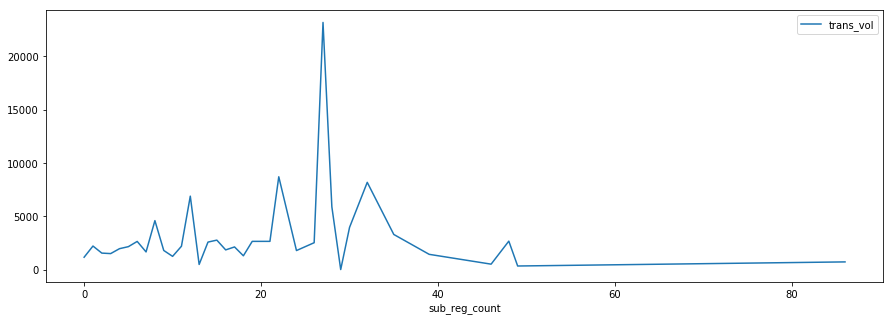

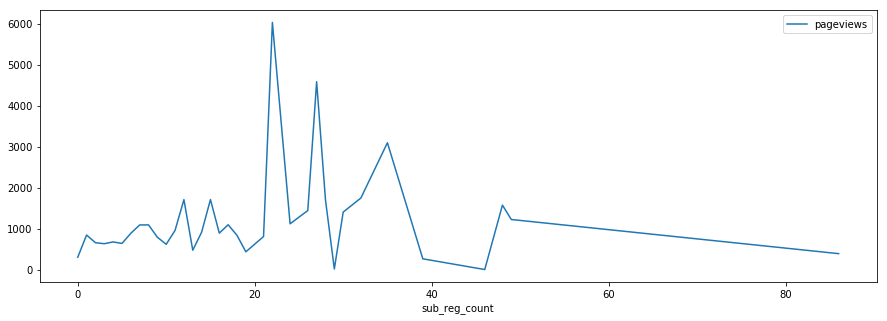

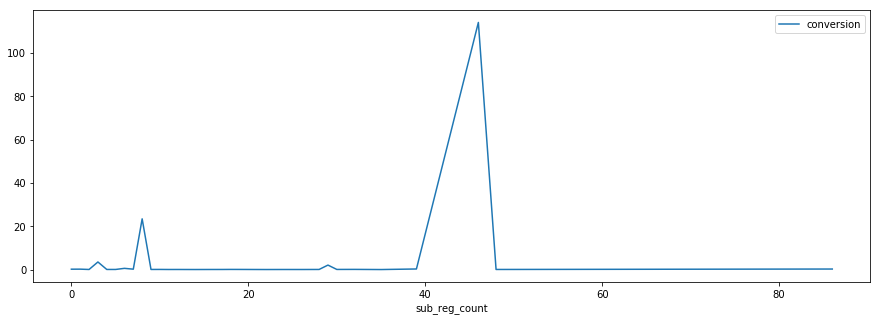

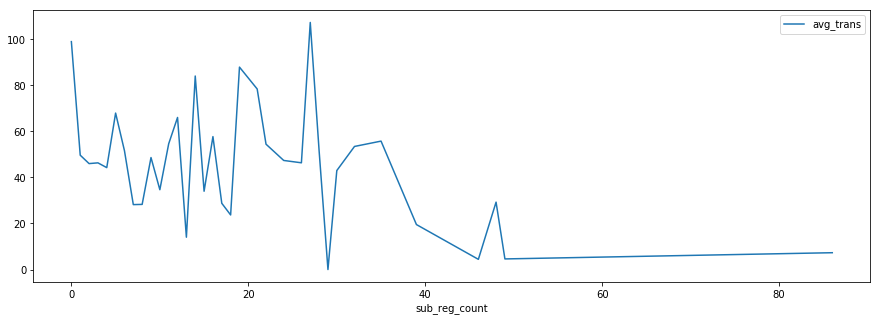

In [134]:
print(buckets_subreg_count[['sub_reg_count', 'trans_count']].plot(x='sub_reg_count', y='trans_count', figsize=(15,5)))
print(buckets_subreg_count[['sub_reg_count', 'trans_vol']].plot(x='sub_reg_count', y='trans_vol', figsize=(15,5)))
print(buckets_subreg_count[['sub_reg_count', 'pageviews']].plot(x='sub_reg_count', y='pageviews', figsize=(15,5)))
print(buckets_subreg_count[['sub_reg_count', 'conversion']].plot(x='sub_reg_count', y='conversion', figsize=(15,5)))
print(buckets_subreg_count[['sub_reg_count', 'avg_trans']].plot(x='sub_reg_count', y='avg_trans', figsize=(15,5)))

### teams count

In [135]:
buckets_teams_count = df_an.groupby('teams_count')[target_cols].mean().reset_index()

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


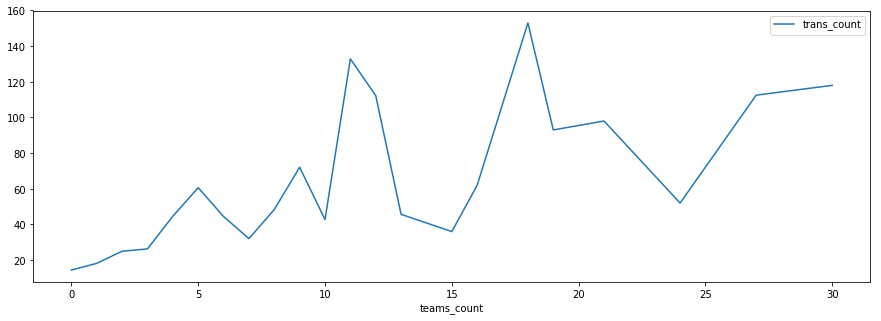

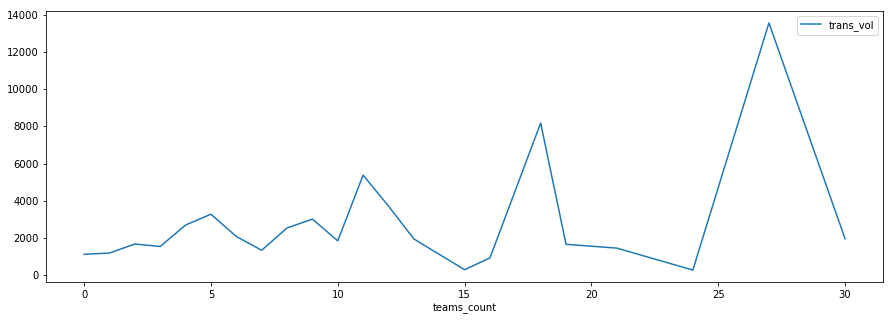

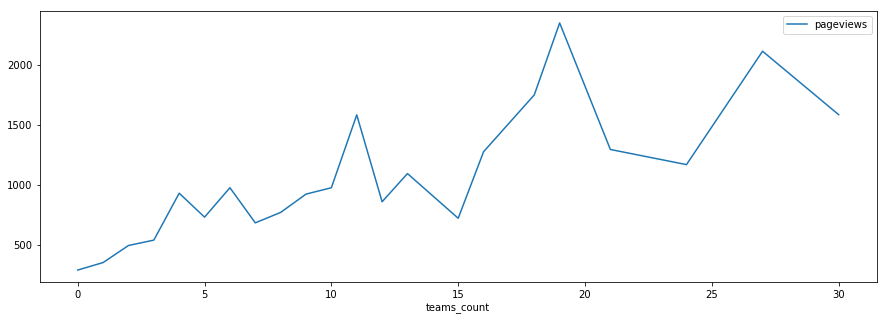

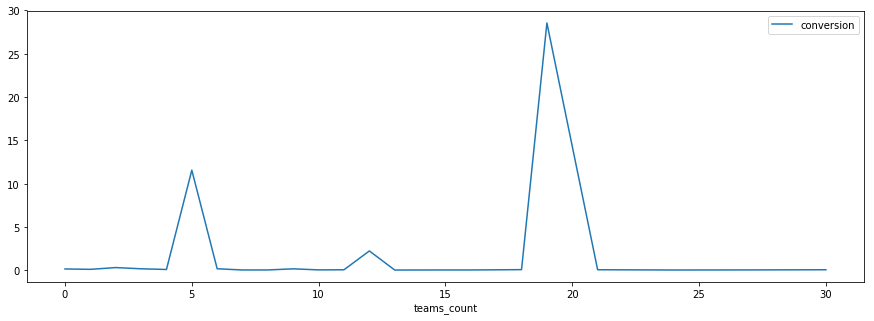

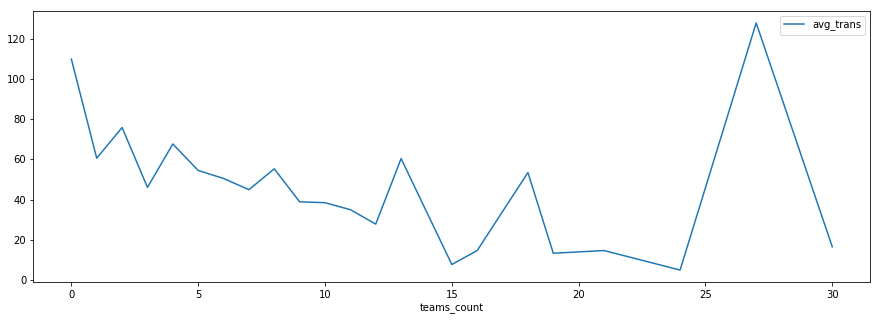

In [136]:
print(buckets_teams_count[['teams_count', 'trans_count']].plot(x='teams_count', y='trans_count', figsize=(15,5)))
print(buckets_teams_count[['teams_count', 'trans_vol']].plot(x='teams_count', y='trans_vol', figsize=(15,5)))
print(buckets_teams_count[['teams_count', 'pageviews']].plot(x='teams_count', y='pageviews', figsize=(15,5)))
print(buckets_teams_count[['teams_count', 'conversion']].plot(x='teams_count', y='conversion', figsize=(15,5)))
print(buckets_teams_count[['teams_count', 'avg_trans']].plot(x='teams_count', y='avg_trans', figsize=(15,5)))

### class_count

In [137]:
buckets_class_count = df_an.groupby('class_count')[target_cols].mean().reset_index()

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


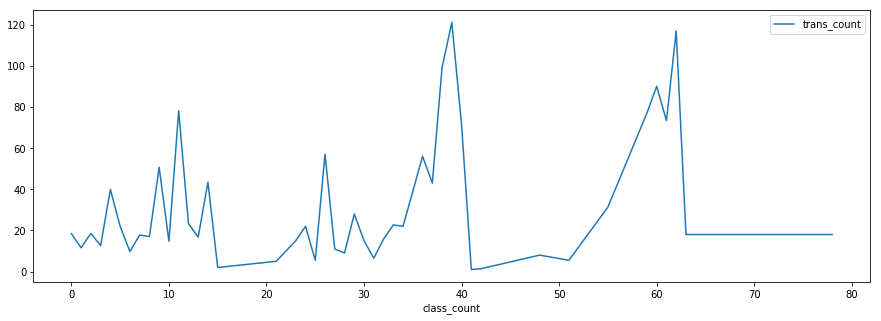

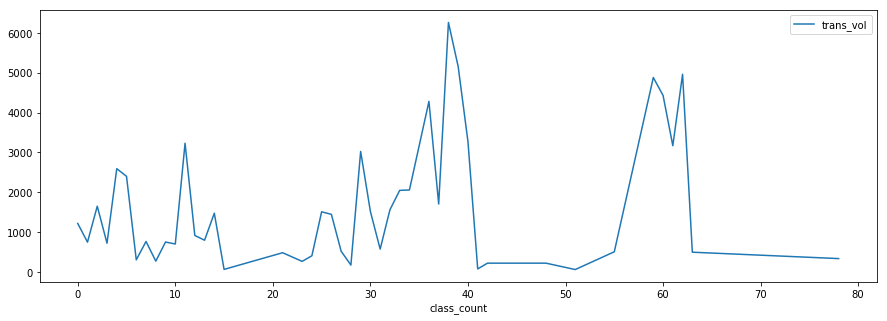

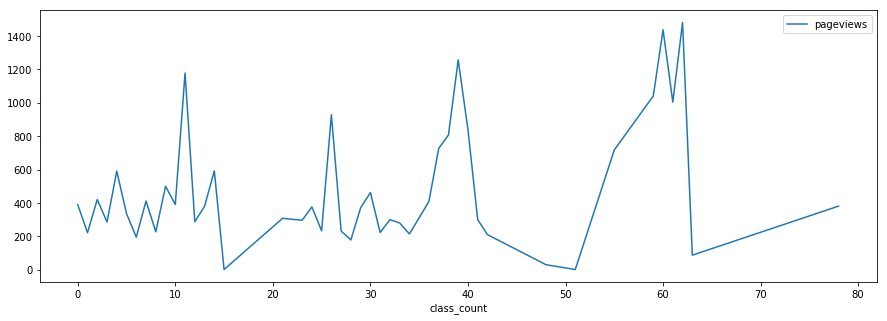

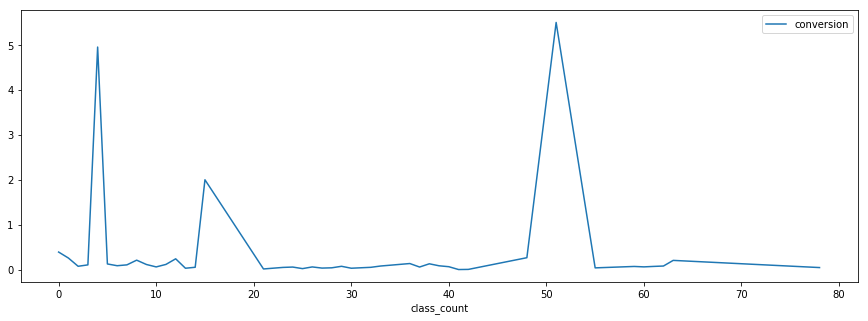

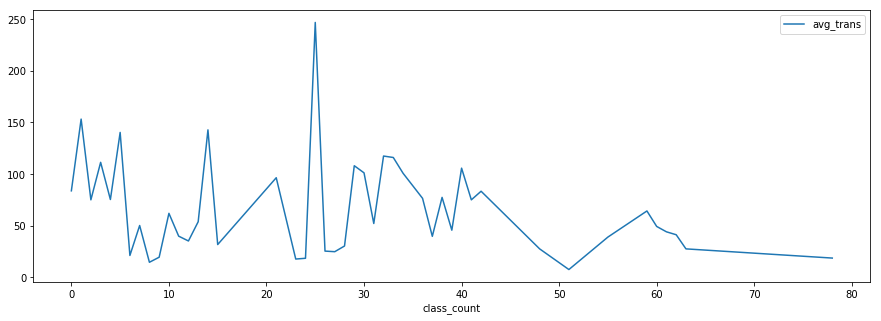

In [138]:
print(buckets_class_count[['class_count', 'trans_count']].plot(x='class_count', y='trans_count', figsize=(15,5)))
print(buckets_class_count[['class_count', 'trans_vol']].plot(x='class_count', y='trans_vol', figsize=(15,5)))
print(buckets_class_count[['class_count', 'pageviews']].plot(x='class_count', y='pageviews', figsize=(15,5)))
print(buckets_class_count[['class_count', 'conversion']].plot(x='class_count', y='conversion', figsize=(15,5)))
print(buckets_class_count[['class_count', 'avg_trans']].plot(x='class_count', y='avg_trans', figsize=(15,5)))

### promo_count

In [139]:
buckets_promo_count = df_an.groupby('promo_count')[target_cols].mean().reset_index()

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


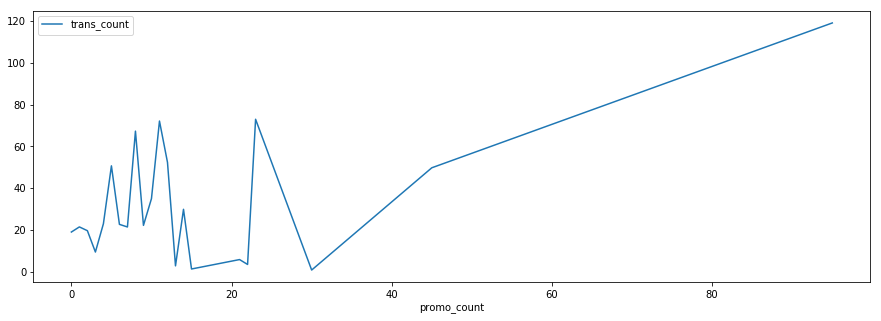

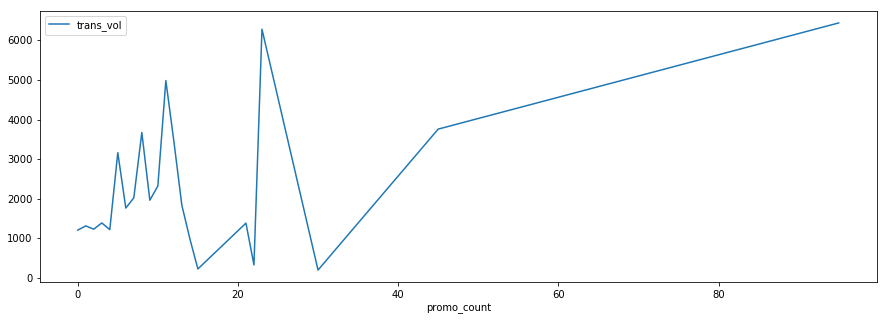

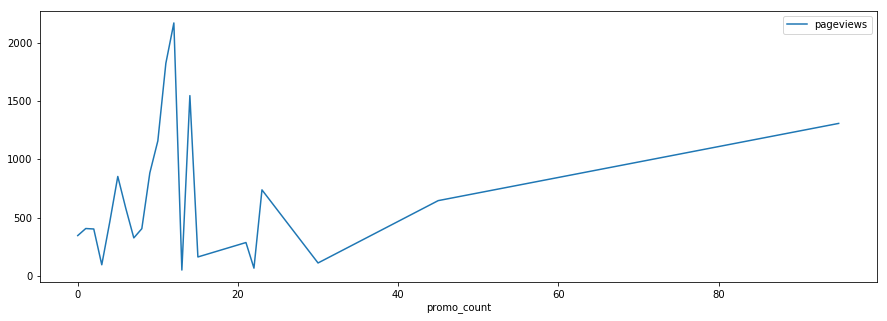

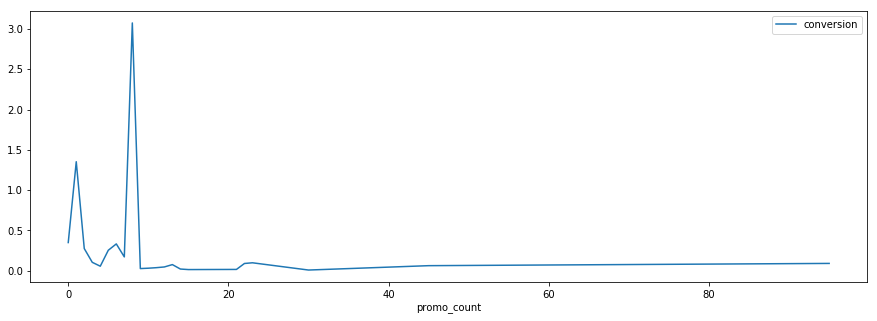

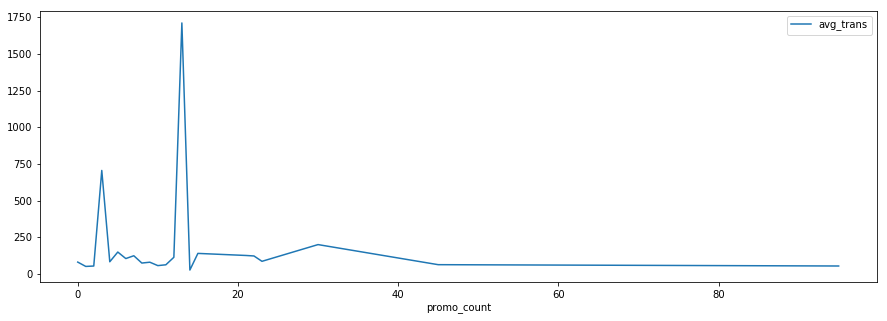

In [140]:
print(buckets_promo_count[['promo_count', 'trans_count']].plot(x='promo_count', y='trans_count', figsize=(15,5)))
print(buckets_promo_count[['promo_count', 'trans_vol']].plot(x='promo_count', y='trans_vol', figsize=(15,5)))
print(buckets_promo_count[['promo_count', 'pageviews']].plot(x='promo_count', y='pageviews', figsize=(15,5)))
print(buckets_promo_count[['promo_count', 'conversion']].plot(x='promo_count', y='conversion', figsize=(15,5)))
print(buckets_promo_count[['promo_count', 'avg_trans']].plot(x='promo_count', y='avg_trans', figsize=(15,5)))

### cat_count

In [141]:
buckets_cat_count = df_an.groupby('cat_count')[target_cols].mean().reset_index()

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


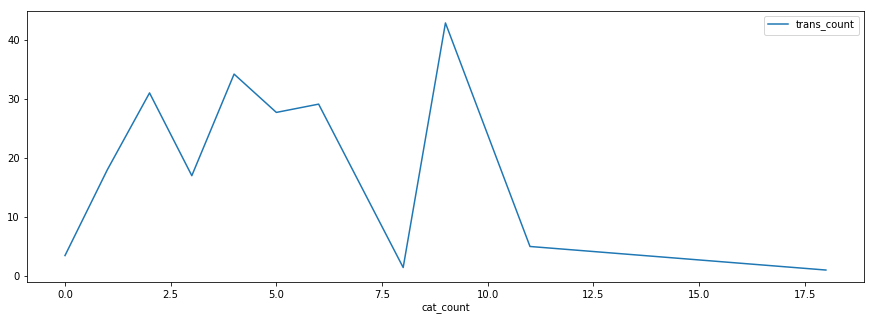

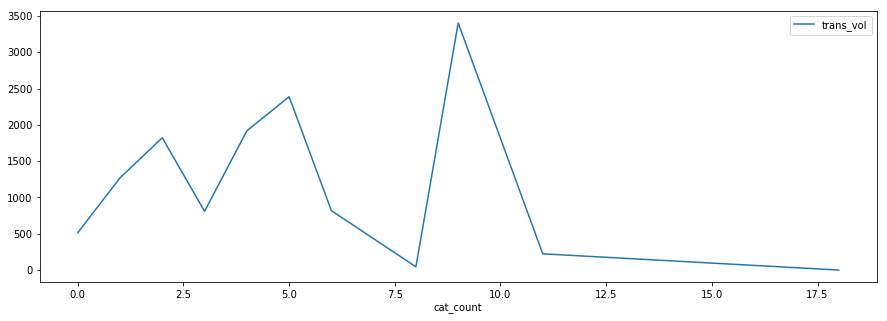

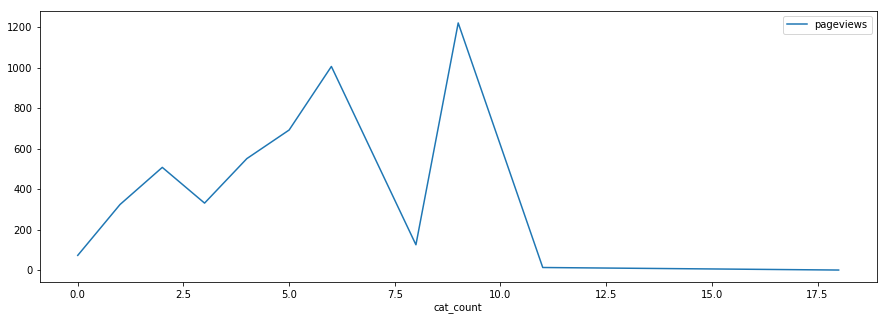

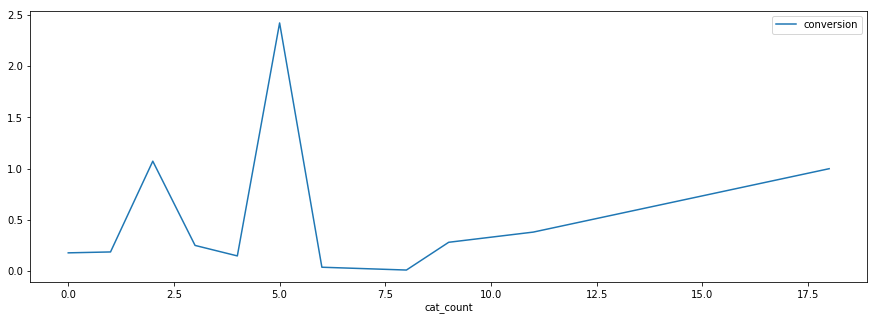

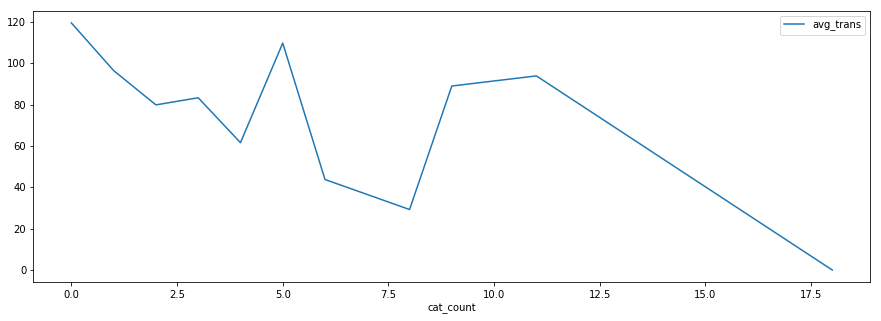

In [142]:
print(buckets_cat_count[['cat_count', 'trans_count']].plot(x='cat_count', y='trans_count', figsize=(15,5)))
print(buckets_cat_count[['cat_count', 'trans_vol']].plot(x='cat_count', y='trans_vol', figsize=(15,5)))
print(buckets_cat_count[['cat_count', 'pageviews']].plot(x='cat_count', y='pageviews', figsize=(15,5)))
print(buckets_cat_count[['cat_count', 'conversion']].plot(x='cat_count', y='conversion', figsize=(15,5)))
print(buckets_cat_count[['cat_count', 'avg_trans']].plot(x='cat_count', y='avg_trans', figsize=(15,5)))